In [28]:
import torch
import torchvision
import torchvision.datasets as datasets
from tqdm import tqdm
import argparse
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torch.backends.cudnn as cudnn
import os
import sys
import logging
import logging.handlers
from PIL import Image

# Parser

In [29]:
parser = argparse.ArgumentParser(description='Domain adaptation')
parser.add_argument("--batch_size", type=int, default="100", help="batch size")
parser.add_argument("--learning_rate", type=float, default=1e-2, help="learning rate")
parser.add_argument("--momentum", type=float, default=0.5, help="momentum")
parser.add_argument("--gpu_num", type=int, default=0, help="gpu num")
parser.add_argument("--seed", type=int, default=123, help="munually set seed")
parser.add_argument("--save_path", type=str, default=r"C:\Users\Tianqin Li\Code\PGM-project\train_related", help="save path")
parser.add_argument("--subfolder", type=str, default=r'\baseline_st', help="subfolder name")
parser.add_argument("--wtarget", type=float, default=0.7, help="target weight")
parser.add_argument("--model_save_period", type=int, default=2, help="save period")


args = parser.parse_args()

usage: ipykernel_launcher.py [-h] [--batch_size BATCH_SIZE]
                             [--learning_rate LEARNING_RATE]
                             [--momentum MOMENTUM] [--gpu_num GPU_NUM]
                             [--seed SEED] [--save_path SAVE_PATH]
                             [--subfolder SUBFOLDER] [--wtarget WTARGET]
                             [--model_save_period MODEL_SAVE_PERIOD]
ipykernel_launcher.py: error: unrecognized arguments: -f C:\Users\Tianqin Li\AppData\Roaming\jupyter\runtime\kernel-6d6e9859-66d6-4d72-9288-8a46d5bf98bc.json


SystemExit: 2

C:\Users\Tianqin Li\anaconda3\envs\russ-local\lib\site-packages\IPython\core\interactiveshell.py:3339: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# local only

In [30]:
# local only
class local_args:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
args = local_args(**{
    'batch_size': 400,
    'learning_rate': 1e-3,
    'momentum': 0.5,
    'gpu_num': 0,
    'seed': 123,
    'save_path': r"C:\Users\Tianqin Li\Code\PGM-project\train_related",
    'epochs': 200,
    'subfolder': r'\paper_dann_source_only_shffle',
    'wtarget': 0.7,
    'dann_weight': 1e-2,
    'model_save_period': 2,
})

In [31]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
# seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)
cudnn.deterministic = True
torch.backends.cudnn.deterministic = True



device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')

 
model_sub_folder = args.subfolder + '\wtarget_%f_dann_weight_%f_learningrate_%f'%(args.wtarget, args.dann_weight, args.learning_rate)

if not os.path.exists(args.save_path+model_sub_folder):
    os.makedirs(args.save_path+model_sub_folder)

In [32]:

logger = logging.getLogger()
logger.setLevel(logging.INFO)

if os.path.isfile(args.save_path+model_sub_folder+ '\logfile.log'):
    os.remove(args.save_path+model_sub_folder+ '\logfile.log')
    
file_log_handler = logging.FileHandler(args.save_path+model_sub_folder+ '\logfile.log')
logger.addHandler(file_log_handler)

stdout_log_handler = logging.StreamHandler(sys.stdout)
logger.addHandler(stdout_log_handler)

attrs = vars(args)
for item in attrs.items():
    logger.info("%s: %s"%item)


batch_size: 400
batch_size: 400
learning_rate: 0.001
learning_rate: 0.001
momentum: 0.5
momentum: 0.5
gpu_num: 0
gpu_num: 0
seed: 123
seed: 123
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
save_path: C:\Users\Tianqin Li\Code\PGM-project\train_related
epochs: 200
epochs: 200
subfolder: \paper_dann_source_only_shffle
subfolder: \paper_dann_source_only_shffle
wtarget: 0.7
wtarget: 0.7
dann_weight: 0.01
dann_weight: 0.01
model_save_period: 2
model_save_period: 2


# Data loader

In [33]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [34]:
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

In [35]:
svhn_trainset = datasets.SVHN(root='./data', split='train', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\train_32x32.mat


In [36]:
svhn_testset = datasets.SVHN(root='./data', split='test', download=True, transform=torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])]))

Using downloaded and verified file: ./data\test_32x32.mat


In [37]:
# # mnist
# train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
# test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(test_mnist_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [38]:
# # svhn
# train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
# examples = enumerate(train_svhn_loader)
# batch_idx, (example_data, example_targets) = next(examples)


# fig = plt.figure()
# for i in range(6):
#   plt.subplot(2,3,i+1)
#   plt.tight_layout()
#   plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
#   plt.title("Ground Truth: {}".format(example_targets[i]))
#   plt.xticks([])
#   plt.yticks([])

In [39]:
# reload data
train_mnist_loader = DataLoader(mnist_trainset, batch_size=args.batch_size, shuffle=True)
test_mnist_loader = DataLoader(mnist_testset, batch_size=args.batch_size, shuffle=True)
train_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)
test_svhn_loader = DataLoader(svhn_trainset, batch_size=args.batch_size, shuffle=True)

## Process data for cancat with source and target label

In [40]:
class ConcatDataset(Dataset):
    def __init__(self, x, y, mode='mnist'):
        self.x = x
        self.y = y
        self.len = self.x.shape[0]
        self.mode = mode
        if self.mode == 'mnist':
            self.transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])
        elif self.mode == 'svhn':
            self.transform = torchvision.transforms.Compose([
                    torchvision.transforms.Resize((28, 28)),
                    torchvision.transforms.Grayscale(num_output_channels=1),
                    torchvision.transforms.ToTensor(),
                    torchvision.transforms.Normalize([0.5], [0.5])])

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        if self.mode == 'mnist':
            img = Image.fromarray(self.x[index].numpy(), mode='L')
            img = self.transform(img)
        elif self.mode == 'svhn':
            img = Image.fromarray(np.transpose(self.x[index], (1, 2, 0)))
            img = self.transform(img)
    
        return img, self.y[index]

In [41]:

concat_mnist_train = ConcatDataset(mnist_trainset.data, torch.zeros(mnist_trainset.data.shape[0], dtype=torch.long), mode = 'mnist')
concat_svhn_train = ConcatDataset(svhn_trainset.data, torch.ones(svhn_trainset.data.shape[0], dtype=torch.long), mode = 'svhn')


adverial_dataset = torch.utils.data.ConcatDataset([concat_mnist_train, concat_svhn_train])
# [i[1] for i in [adverial_dataset[m] for m in torch.randint(0, len(adverial_dataset), (100,))]]
adverial_loader = DataLoader(adverial_dataset, batch_size=args.batch_size, shuffle=True)

# Model

In [42]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 30)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

In [43]:
class FNN(nn.Module):
    def __init__(self, d_in, d_h1, d_h2, d_out, dp=0.2):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(d_in, d_h1)
        self.ln1 = nn.LayerNorm(d_h1)
        self.relu1 = nn.ReLU(inplace=True)
        self.dropout1 = nn.Dropout(dp)
        self.fc2 = nn.Linear(d_h1, d_h2)
        self.ln2 = nn.LayerNorm(d_h2)
        self.relu2 = nn.ReLU(inplace=True)
        self.dropout2 = nn.Dropout(dp)
        self.fc3 = nn.Linear(d_h2, d_out)

    def forward(self, x):
        x = self.fc1(x)
        x = self.ln1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.ln2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)

        return x

In [44]:
class Adversial_loss(nn.Module):
    def __init__(self):
        super(Adversial_loss, self).__init__()
    
    def forward(self):
        pass

In [45]:
def weights_init(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
    elif type(m) == nn.LayerNorm:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [46]:

device = torch.device('cuda:{}'.format(args.gpu_num) if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
np.random.seed(args.seed)

encoder = Encoder().to(device)
CNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=10, dp=0.2).to(device)
DomainCNet = FNN(d_in=30, d_h1=100, d_h2=100, d_out=2, dp=0.2).to(device)




optimizerEncoder = optim.Adam(encoder.parameters(), lr=args.learning_rate)
optimizerCNet = optim.Adam(CNet.parameters(), lr=args.learning_rate)
optimizerDomainCNet = optim.Adam(DomainCNet.parameters(), lr=args.learning_rate)

criterion_classifier = nn.CrossEntropyLoss().to(device)
# criterion_adverisal = 

encoder.apply(weights_init)
CNet.apply(weights_init)
DomainCNet.apply(weights_init)

cuda:0


FNN(
  (fc1): Linear(in_features=30, out_features=100, bias=True)
  (ln1): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu1): ReLU(inplace=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (ln2): LayerNorm((100,), eps=1e-05, elementwise_affine=True)
  (relu2): ReLU(inplace=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc3): Linear(in_features=100, out_features=2, bias=True)
)

# Train

In [48]:
target_acc_label_ = []
source_acc_ = []
source_test_acc_ = []
target_test_acc_ = []

logger.info('Started Training')


for epoch in range(args.epochs):
    # update classifier
    # on source domain mnist
    CNet.train()
    encoder.train()
    source_acc = 0.0
    num_datas = 0.0
    for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_acc += (pred.argmax(-1) == source_y).sum().item()
        loss = criterion_classifier(pred, source_y)
        loss.backward()
        optimizerCNet.step()
        optimizerEncoder.step()
        
        
    source_acc = source_acc / num_datas
    source_acc_.append(source_acc)
    
    
    
    # on target domain svhn
#     target_acc = 0.0
#     num_datas = 0.0
#     CNet.train()
#     encoder.train()

#     for batch_id, (target_x, target_y) in tqdm(enumerate(train_svhn_loader), total=len(train_svhn_loader)):
#         optimizerCNet.zero_grad()
#         optimizerEncoder.zero_grad()
#         target_x = target_x.to(device).float()
#         target_y = target_y.to(device)
#         num_datas += target_x.size(0)
#         target_x_embedding = encoder(target_x)
#         pred = CNet(target_x_embedding)
#         target_acc += (pred.argmax(-1) == target_y).sum().item()
#         loss = criterion_classifier(pred, target_y)
#         loss.backward()
#         optimizerCNet.step()
#         optimizerEncoder.step()
        
    
#     target_acc = target_acc / num_datas
#     target_acc_label_.append(target_acc)
    
    
    # DANN
#     DomainCNet.train()
#     encoder.train()
    num_datas = 0.0
    for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
        # domain layer loss
        DomainCNet.train()
        encoder.train()
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        adv_x = adv_x.to(device).float()
        adv_y = adv_y.to(device)
        adv_x_embedding = encoder(adv_x)
        pred = DomainCNet(adv_x_embedding)
        # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
        loss_adv = args.dann_weight * criterion_classifier(pred, adv_y)
        loss_adv.backward()
        optimizerDomainCNet.step()
    
    for batch_id, (adv_x, adv_y) in tqdm(enumerate(adverial_loader), total=len(adverial_loader)):
        # domain layer loss
        DomainCNet.train()
        encoder.train()
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        adv_x = adv_x.to(device).float()
        adv_y = adv_y.to(device)
        adv_x_embedding = encoder(adv_x)
        pred = DomainCNet(adv_x_embedding)
        # adv_acc += (pred.argmax(-1) == adv_y).sum().item()
        loss_adv = -args.dann_weight * criterion_classifier(pred, adv_y)
        loss_adv.backward()
        optimizerEncoder.step()

        
#         DomainCNet.eval()
#         encoder.train()
#         optimizerEncoder.zero_grad()
#         adv_x_embedding = encoder(adv_x)
#         pred = DomainCNet(adv_x_embedding)
#         loss_adv = -args.dann_weight * criterion_classifier(pred, adv_y)
#         loss.backward()
#         optimizerEncoder.step()
    
    
    
    
    # eval on source   
    source_test_acc = 0.0
    num_datas = 0.0
    CNet.eval()
    encoder.eval()
    
    for batch_id, (source_x, source_y) in enumerate(test_mnist_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        source_x = source_x.to(device).float()
        source_y = source_y.to(device)
        num_datas += source_x.size(0)
        source_x_embedding = encoder(source_x)
        pred = CNet(source_x_embedding)
        source_test_acc += (pred.argmax(-1) == source_y).sum().item()
        
    source_test_acc = source_test_acc / num_datas
    source_test_acc_.append(source_test_acc)
    
    # eval on target 
    num_datas = 0.0
    target_test_acc = 0.0
    for batch_id, (target_x, target_y) in enumerate(test_svhn_loader):
        optimizerCNet.zero_grad()
        optimizerEncoder.zero_grad()
        target_x = target_x.to(device).float()
        target_y = target_y.to(device)
        num_datas += target_x.size(0)
        target_x_embedding = encoder(target_x)
        pred = CNet(target_x_embedding)
        target_test_acc += (pred.argmax(-1) == target_y).sum().item()
    
    target_test_acc = target_test_acc / num_datas
    target_test_acc_.append(source_test_acc)
    
    if epoch % args.model_save_period == 0:
        torch.save(DomainCNet.state_dict(), args.save_path+model_sub_folder+ '/DomainCNet_%i.t7'%(epoch+1))
        torch.save(encoder.state_dict(), args.save_path+model_sub_folder+ '/encoder_%i.t7'%(epoch+1))
        torch.save(CNet.state_dict(), args.save_path+model_sub_folder+ '/CNet_%i.t7'%(epoch+1))

    
    logger.info('Epochs %i: source train acc: %f; source test acc: %f; target test acc: %f'%(epoch+1, source_acc, source_test_acc, target_test_acc))
    

Started Training
Started Training


100%|██████████| 334/334 [00:20<00:00, 16.53it/s]


Epochs 1: source train acc: 0.977683; source test acc: 0.969800; target test acc: 0.159357
Epochs 1: source train acc: 0.977683; source test acc: 0.969800; target test acc: 0.159357


100%|██████████| 334/334 [00:20<00:00, 16.55it/s]


Epochs 2: source train acc: 0.975617; source test acc: 0.991800; target test acc: 0.201414
Epochs 2: source train acc: 0.975617; source test acc: 0.991800; target test acc: 0.201414


100%|██████████| 334/334 [00:20<00:00, 16.38it/s]


Epochs 3: source train acc: 0.976467; source test acc: 0.991800; target test acc: 0.207789
Epochs 3: source train acc: 0.976467; source test acc: 0.991800; target test acc: 0.207789


100%|██████████| 334/334 [00:20<00:00, 16.43it/s]


Epochs 4: source train acc: 0.978333; source test acc: 0.989100; target test acc: 0.218450
Epochs 4: source train acc: 0.978333; source test acc: 0.989100; target test acc: 0.218450


100%|██████████| 334/334 [00:20<00:00, 16.55it/s]


Epochs 5: source train acc: 0.976467; source test acc: 0.991000; target test acc: 0.210205
Epochs 5: source train acc: 0.976467; source test acc: 0.991000; target test acc: 0.210205


100%|██████████| 334/334 [00:20<00:00, 16.42it/s]


Epochs 6: source train acc: 0.977250; source test acc: 0.306400; target test acc: 0.200322
Epochs 6: source train acc: 0.977250; source test acc: 0.306400; target test acc: 0.200322


100%|██████████| 334/334 [00:20<00:00, 16.53it/s]


Epochs 7: source train acc: 0.951667; source test acc: 0.101400; target test acc: 0.196869
Epochs 7: source train acc: 0.951667; source test acc: 0.101400; target test acc: 0.196869


100%|██████████| 334/334 [00:20<00:00, 16.31it/s]


Epochs 8: source train acc: 0.881250; source test acc: 0.124100; target test acc: 0.217754
Epochs 8: source train acc: 0.881250; source test acc: 0.124100; target test acc: 0.217754


100%|██████████| 334/334 [00:20<00:00, 16.59it/s]


Epochs 9: source train acc: 0.895183; source test acc: 0.110100; target test acc: 0.224770
Epochs 9: source train acc: 0.895183; source test acc: 0.110100; target test acc: 0.224770


100%|██████████| 334/334 [00:20<00:00, 16.35it/s]


Epochs 10: source train acc: 0.905617; source test acc: 0.204300; target test acc: 0.222081
Epochs 10: source train acc: 0.905617; source test acc: 0.204300; target test acc: 0.222081


100%|██████████| 334/334 [00:20<00:00, 16.60it/s]


Epochs 11: source train acc: 0.915617; source test acc: 0.364900; target test acc: 0.214519
Epochs 11: source train acc: 0.915617; source test acc: 0.364900; target test acc: 0.214519


100%|██████████| 334/334 [00:20<00:00, 16.23it/s]


Epochs 12: source train acc: 0.927250; source test acc: 0.324400; target test acc: 0.176898
Epochs 12: source train acc: 0.927250; source test acc: 0.324400; target test acc: 0.176898


100%|██████████| 334/334 [00:20<00:00, 16.59it/s]


Epochs 13: source train acc: 0.929183; source test acc: 0.375400; target test acc: 0.140287
Epochs 13: source train acc: 0.929183; source test acc: 0.375400; target test acc: 0.140287


100%|██████████| 334/334 [00:20<00:00, 16.33it/s]


Epochs 14: source train acc: 0.919600; source test acc: 0.257900; target test acc: 0.141597
Epochs 14: source train acc: 0.919600; source test acc: 0.257900; target test acc: 0.141597


100%|██████████| 334/334 [00:20<00:00, 16.69it/s]


Epochs 15: source train acc: 0.878500; source test acc: 0.115000; target test acc: 0.115184
Epochs 15: source train acc: 0.878500; source test acc: 0.115000; target test acc: 0.115184


100%|██████████| 334/334 [00:20<00:00, 16.34it/s]


Epochs 16: source train acc: 0.672600; source test acc: 0.097400; target test acc: 0.074546
Epochs 16: source train acc: 0.672600; source test acc: 0.097400; target test acc: 0.074546


100%|██████████| 334/334 [00:19<00:00, 16.77it/s]


Epochs 17: source train acc: 0.559217; source test acc: 0.298400; target test acc: 0.079460
Epochs 17: source train acc: 0.559217; source test acc: 0.298400; target test acc: 0.079460


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 18: source train acc: 0.836600; source test acc: 0.502700; target test acc: 0.114897
Epochs 18: source train acc: 0.836600; source test acc: 0.502700; target test acc: 0.114897


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 19: source train acc: 0.829133; source test acc: 0.422700; target test acc: 0.200063
Epochs 19: source train acc: 0.829133; source test acc: 0.422700; target test acc: 0.200063


100%|██████████| 334/334 [00:19<00:00, 17.11it/s]


Epochs 20: source train acc: 0.774133; source test acc: 0.177100; target test acc: 0.165404
Epochs 20: source train acc: 0.774133; source test acc: 0.177100; target test acc: 0.165404


100%|██████████| 334/334 [00:19<00:00, 17.17it/s]


Epochs 21: source train acc: 0.634183; source test acc: 0.181300; target test acc: 0.121285
Epochs 21: source train acc: 0.634183; source test acc: 0.181300; target test acc: 0.121285


100%|██████████| 334/334 [00:19<00:00, 17.16it/s]


Epochs 22: source train acc: 0.472533; source test acc: 0.107300; target test acc: 0.096291
Epochs 22: source train acc: 0.472533; source test acc: 0.107300; target test acc: 0.096291


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 23: source train acc: 0.140033; source test acc: 0.089200; target test acc: 0.094298
Epochs 23: source train acc: 0.140033; source test acc: 0.089200; target test acc: 0.094298


100%|██████████| 334/334 [00:19<00:00, 17.17it/s]


Epochs 24: source train acc: 0.108917; source test acc: 0.113500; target test acc: 0.189211
Epochs 24: source train acc: 0.108917; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 17.16it/s]


Epochs 25: source train acc: 0.106217; source test acc: 0.113500; target test acc: 0.189211
Epochs 25: source train acc: 0.106217; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 17.19it/s]


Epochs 26: source train acc: 0.108383; source test acc: 0.113500; target test acc: 0.189211
Epochs 26: source train acc: 0.108383; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 16.92it/s]


Epochs 27: source train acc: 0.108233; source test acc: 0.113500; target test acc: 0.189211
Epochs 27: source train acc: 0.108233; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 16.90it/s]


Epochs 28: source train acc: 0.110633; source test acc: 0.113500; target test acc: 0.189211
Epochs 28: source train acc: 0.110633; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 16.96it/s]


Epochs 29: source train acc: 0.108350; source test acc: 0.113500; target test acc: 0.189211
Epochs 29: source train acc: 0.108350; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 30: source train acc: 0.110133; source test acc: 0.113500; target test acc: 0.189211
Epochs 30: source train acc: 0.110133; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 17.00it/s]


Epochs 31: source train acc: 0.112283; source test acc: 0.113500; target test acc: 0.189211
Epochs 31: source train acc: 0.112283; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 32: source train acc: 0.112167; source test acc: 0.113500; target test acc: 0.189211
Epochs 32: source train acc: 0.112167; source test acc: 0.113500; target test acc: 0.189211


100%|██████████| 334/334 [00:19<00:00, 16.96it/s]


Epochs 33: source train acc: 0.130050; source test acc: 0.413900; target test acc: 0.184747
Epochs 33: source train acc: 0.130050; source test acc: 0.413900; target test acc: 0.184747


100%|██████████| 334/334 [00:19<00:00, 16.87it/s]


Epochs 34: source train acc: 0.783717; source test acc: 0.986600; target test acc: 0.246707
Epochs 34: source train acc: 0.783717; source test acc: 0.986600; target test acc: 0.246707


100%|██████████| 334/334 [00:19<00:00, 16.79it/s]


Epochs 35: source train acc: 0.955333; source test acc: 0.988100; target test acc: 0.245028
Epochs 35: source train acc: 0.955333; source test acc: 0.988100; target test acc: 0.245028


100%|██████████| 334/334 [00:19<00:00, 16.95it/s]


Epochs 36: source train acc: 0.962633; source test acc: 0.989700; target test acc: 0.242161
Epochs 36: source train acc: 0.962633; source test acc: 0.989700; target test acc: 0.242161


100%|██████████| 334/334 [00:19<00:00, 16.91it/s]


Epochs 37: source train acc: 0.965983; source test acc: 0.990000; target test acc: 0.237138
Epochs 37: source train acc: 0.965983; source test acc: 0.990000; target test acc: 0.237138


100%|██████████| 334/334 [00:19<00:00, 16.91it/s]


Epochs 38: source train acc: 0.968033; source test acc: 0.990400; target test acc: 0.233561
Epochs 38: source train acc: 0.968033; source test acc: 0.990400; target test acc: 0.233561


100%|██████████| 334/334 [00:19<00:00, 16.87it/s]


Epochs 39: source train acc: 0.970000; source test acc: 0.990500; target test acc: 0.227937
Epochs 39: source train acc: 0.970000; source test acc: 0.990500; target test acc: 0.227937


100%|██████████| 334/334 [00:19<00:00, 16.90it/s]


Epochs 40: source train acc: 0.971967; source test acc: 0.991200; target test acc: 0.226381
Epochs 40: source train acc: 0.971967; source test acc: 0.991200; target test acc: 0.226381


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 41: source train acc: 0.972983; source test acc: 0.991000; target test acc: 0.225248
Epochs 41: source train acc: 0.972983; source test acc: 0.991000; target test acc: 0.225248


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 42: source train acc: 0.973100; source test acc: 0.990900; target test acc: 0.221576
Epochs 42: source train acc: 0.973100; source test acc: 0.990900; target test acc: 0.221576


100%|██████████| 334/334 [00:19<00:00, 16.92it/s]


Epochs 43: source train acc: 0.972933; source test acc: 0.990900; target test acc: 0.222450
Epochs 43: source train acc: 0.972933; source test acc: 0.990900; target test acc: 0.222450


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 44: source train acc: 0.974217; source test acc: 0.990600; target test acc: 0.221098
Epochs 44: source train acc: 0.974217; source test acc: 0.990600; target test acc: 0.221098


100%|██████████| 334/334 [00:19<00:00, 16.93it/s]


Epochs 45: source train acc: 0.974967; source test acc: 0.991900; target test acc: 0.220525
Epochs 45: source train acc: 0.974967; source test acc: 0.991900; target test acc: 0.220525


100%|██████████| 334/334 [00:19<00:00, 17.08it/s]


Epochs 46: source train acc: 0.974933; source test acc: 0.991700; target test acc: 0.215706
Epochs 46: source train acc: 0.974933; source test acc: 0.991700; target test acc: 0.215706


100%|██████████| 334/334 [00:19<00:00, 17.13it/s]


Epochs 47: source train acc: 0.975800; source test acc: 0.992200; target test acc: 0.214232
Epochs 47: source train acc: 0.975800; source test acc: 0.992200; target test acc: 0.214232


100%|██████████| 334/334 [00:19<00:00, 16.95it/s]


Epochs 48: source train acc: 0.974833; source test acc: 0.991400; target test acc: 0.214232
Epochs 48: source train acc: 0.974833; source test acc: 0.991400; target test acc: 0.214232


100%|██████████| 334/334 [00:19<00:00, 16.90it/s]


Epochs 49: source train acc: 0.975817; source test acc: 0.991500; target test acc: 0.214123
Epochs 49: source train acc: 0.975817; source test acc: 0.991500; target test acc: 0.214123


100%|██████████| 334/334 [00:19<00:00, 16.96it/s]


Epochs 50: source train acc: 0.977150; source test acc: 0.992700; target test acc: 0.213468
Epochs 50: source train acc: 0.977150; source test acc: 0.992700; target test acc: 0.213468


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 51: source train acc: 0.976550; source test acc: 0.991800; target test acc: 0.214355
Epochs 51: source train acc: 0.976550; source test acc: 0.991800; target test acc: 0.214355


100%|██████████| 334/334 [00:19<00:00, 16.80it/s]


Epochs 52: source train acc: 0.975833; source test acc: 0.991900; target test acc: 0.215870
Epochs 52: source train acc: 0.975833; source test acc: 0.991900; target test acc: 0.215870


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 53: source train acc: 0.977467; source test acc: 0.991200; target test acc: 0.212826
Epochs 53: source train acc: 0.977467; source test acc: 0.991200; target test acc: 0.212826


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 54: source train acc: 0.976217; source test acc: 0.991800; target test acc: 0.214082
Epochs 54: source train acc: 0.976217; source test acc: 0.991800; target test acc: 0.214082


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 55: source train acc: 0.977267; source test acc: 0.991800; target test acc: 0.212485
Epochs 55: source train acc: 0.977267; source test acc: 0.991800; target test acc: 0.212485


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 56: source train acc: 0.976283; source test acc: 0.991500; target test acc: 0.208826
Epochs 56: source train acc: 0.976283; source test acc: 0.991500; target test acc: 0.208826


100%|██████████| 334/334 [00:19<00:00, 16.96it/s]


Epochs 57: source train acc: 0.977317; source test acc: 0.991600; target test acc: 0.214519
Epochs 57: source train acc: 0.977317; source test acc: 0.991600; target test acc: 0.214519


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 58: source train acc: 0.979217; source test acc: 0.991800; target test acc: 0.212034
Epochs 58: source train acc: 0.979217; source test acc: 0.991800; target test acc: 0.212034


100%|██████████| 334/334 [00:19<00:00, 17.12it/s]


Epochs 59: source train acc: 0.977733; source test acc: 0.992000; target test acc: 0.214846
Epochs 59: source train acc: 0.977733; source test acc: 0.992000; target test acc: 0.214846


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 60: source train acc: 0.976933; source test acc: 0.992300; target test acc: 0.208813
Epochs 60: source train acc: 0.976933; source test acc: 0.992300; target test acc: 0.208813


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 61: source train acc: 0.977317; source test acc: 0.991800; target test acc: 0.211338
Epochs 61: source train acc: 0.977317; source test acc: 0.991800; target test acc: 0.211338


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 62: source train acc: 0.977800; source test acc: 0.992200; target test acc: 0.212048
Epochs 62: source train acc: 0.977800; source test acc: 0.992200; target test acc: 0.212048


100%|██████████| 334/334 [00:19<00:00, 17.14it/s]


Epochs 63: source train acc: 0.978317; source test acc: 0.992300; target test acc: 0.208990
Epochs 63: source train acc: 0.978317; source test acc: 0.992300; target test acc: 0.208990


100%|██████████| 334/334 [00:19<00:00, 17.14it/s]


Epochs 64: source train acc: 0.978300; source test acc: 0.992600; target test acc: 0.213167
Epochs 64: source train acc: 0.978300; source test acc: 0.992600; target test acc: 0.213167


100%|██████████| 334/334 [00:19<00:00, 17.11it/s]


Epochs 65: source train acc: 0.978683; source test acc: 0.992700; target test acc: 0.208867
Epochs 65: source train acc: 0.978683; source test acc: 0.992700; target test acc: 0.208867


100%|██████████| 334/334 [00:19<00:00, 17.08it/s]


Epochs 66: source train acc: 0.977817; source test acc: 0.992400; target test acc: 0.209973
Epochs 66: source train acc: 0.977817; source test acc: 0.992400; target test acc: 0.209973


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 67: source train acc: 0.978433; source test acc: 0.993000; target test acc: 0.211024
Epochs 67: source train acc: 0.978433; source test acc: 0.993000; target test acc: 0.211024


100%|██████████| 334/334 [00:19<00:00, 16.94it/s]


Epochs 68: source train acc: 0.977200; source test acc: 0.993300; target test acc: 0.213577
Epochs 68: source train acc: 0.977200; source test acc: 0.993300; target test acc: 0.213577


100%|██████████| 334/334 [00:19<00:00, 16.70it/s]


Epochs 69: source train acc: 0.979000; source test acc: 0.992400; target test acc: 0.216184
Epochs 69: source train acc: 0.979000; source test acc: 0.992400; target test acc: 0.216184


100%|██████████| 334/334 [00:19<00:00, 17.06it/s]


Epochs 70: source train acc: 0.979867; source test acc: 0.992900; target test acc: 0.213768
Epochs 70: source train acc: 0.979867; source test acc: 0.992900; target test acc: 0.213768


100%|██████████| 334/334 [00:19<00:00, 16.84it/s]


Epochs 71: source train acc: 0.977733; source test acc: 0.992600; target test acc: 0.216471
Epochs 71: source train acc: 0.977733; source test acc: 0.992600; target test acc: 0.216471


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 72: source train acc: 0.978033; source test acc: 0.992700; target test acc: 0.212662
Epochs 72: source train acc: 0.978033; source test acc: 0.992700; target test acc: 0.212662


100%|██████████| 334/334 [00:19<00:00, 16.99it/s]


Epochs 73: source train acc: 0.979600; source test acc: 0.992100; target test acc: 0.212253
Epochs 73: source train acc: 0.979600; source test acc: 0.992100; target test acc: 0.212253


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 74: source train acc: 0.978033; source test acc: 0.992900; target test acc: 0.211775
Epochs 74: source train acc: 0.978033; source test acc: 0.992900; target test acc: 0.211775


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 75: source train acc: 0.978900; source test acc: 0.993000; target test acc: 0.211761
Epochs 75: source train acc: 0.978900; source test acc: 0.993000; target test acc: 0.211761


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 76: source train acc: 0.979450; source test acc: 0.991500; target test acc: 0.213713
Epochs 76: source train acc: 0.979450; source test acc: 0.991500; target test acc: 0.213713


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 77: source train acc: 0.979050; source test acc: 0.992600; target test acc: 0.213044
Epochs 77: source train acc: 0.979050; source test acc: 0.992600; target test acc: 0.213044


100%|██████████| 334/334 [00:19<00:00, 16.97it/s]


Epochs 78: source train acc: 0.977467; source test acc: 0.992600; target test acc: 0.212567
Epochs 78: source train acc: 0.977467; source test acc: 0.992600; target test acc: 0.212567


100%|██████████| 334/334 [00:19<00:00, 16.94it/s]


Epochs 79: source train acc: 0.978400; source test acc: 0.992900; target test acc: 0.215583
Epochs 79: source train acc: 0.978400; source test acc: 0.992900; target test acc: 0.215583


100%|██████████| 334/334 [00:19<00:00, 16.96it/s]


Epochs 80: source train acc: 0.978150; source test acc: 0.992700; target test acc: 0.211598
Epochs 80: source train acc: 0.978150; source test acc: 0.992700; target test acc: 0.211598


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 81: source train acc: 0.980117; source test acc: 0.992100; target test acc: 0.213154
Epochs 81: source train acc: 0.980117; source test acc: 0.992100; target test acc: 0.213154


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 82: source train acc: 0.979467; source test acc: 0.992300; target test acc: 0.207639
Epochs 82: source train acc: 0.979467; source test acc: 0.992300; target test acc: 0.207639


100%|██████████| 334/334 [00:19<00:00, 16.93it/s]


Epochs 83: source train acc: 0.979150; source test acc: 0.993100; target test acc: 0.211734
Epochs 83: source train acc: 0.979150; source test acc: 0.993100; target test acc: 0.211734


100%|██████████| 334/334 [00:19<00:00, 16.99it/s]


Epochs 84: source train acc: 0.979483; source test acc: 0.992900; target test acc: 0.210860
Epochs 84: source train acc: 0.979483; source test acc: 0.992900; target test acc: 0.210860


100%|██████████| 334/334 [00:19<00:00, 16.82it/s]


Epochs 85: source train acc: 0.979517; source test acc: 0.992000; target test acc: 0.212771
Epochs 85: source train acc: 0.979517; source test acc: 0.992000; target test acc: 0.212771


100%|██████████| 334/334 [00:19<00:00, 16.93it/s]


Epochs 86: source train acc: 0.979683; source test acc: 0.992500; target test acc: 0.212225
Epochs 86: source train acc: 0.979683; source test acc: 0.992500; target test acc: 0.212225


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 87: source train acc: 0.979733; source test acc: 0.992400; target test acc: 0.209222
Epochs 87: source train acc: 0.979733; source test acc: 0.992400; target test acc: 0.209222


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 88: source train acc: 0.979100; source test acc: 0.992800; target test acc: 0.210847
Epochs 88: source train acc: 0.979100; source test acc: 0.992800; target test acc: 0.210847


100%|██████████| 334/334 [00:19<00:00, 16.92it/s]


Epochs 89: source train acc: 0.979367; source test acc: 0.992300; target test acc: 0.208458
Epochs 89: source train acc: 0.979367; source test acc: 0.992300; target test acc: 0.208458


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 90: source train acc: 0.979367; source test acc: 0.990900; target test acc: 0.208786
Epochs 90: source train acc: 0.979367; source test acc: 0.990900; target test acc: 0.208786


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 91: source train acc: 0.979933; source test acc: 0.992700; target test acc: 0.210778
Epochs 91: source train acc: 0.979933; source test acc: 0.992700; target test acc: 0.210778


100%|██████████| 334/334 [00:19<00:00, 16.74it/s]


Epochs 92: source train acc: 0.979500; source test acc: 0.992400; target test acc: 0.208485
Epochs 92: source train acc: 0.979500; source test acc: 0.992400; target test acc: 0.208485


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 93: source train acc: 0.979650; source test acc: 0.992900; target test acc: 0.212744
Epochs 93: source train acc: 0.979650; source test acc: 0.992900; target test acc: 0.212744


100%|██████████| 334/334 [00:19<00:00, 17.13it/s]


Epochs 94: source train acc: 0.980183; source test acc: 0.992000; target test acc: 0.212225
Epochs 94: source train acc: 0.980183; source test acc: 0.992000; target test acc: 0.212225


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 95: source train acc: 0.979500; source test acc: 0.992900; target test acc: 0.208321
Epochs 95: source train acc: 0.979500; source test acc: 0.992900; target test acc: 0.208321


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 96: source train acc: 0.979767; source test acc: 0.991800; target test acc: 0.208417
Epochs 96: source train acc: 0.979767; source test acc: 0.991800; target test acc: 0.208417


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 97: source train acc: 0.979350; source test acc: 0.992400; target test acc: 0.212703
Epochs 97: source train acc: 0.979350; source test acc: 0.992400; target test acc: 0.212703


100%|██████████| 334/334 [00:19<00:00, 16.84it/s]


Epochs 98: source train acc: 0.980117; source test acc: 0.992100; target test acc: 0.211625
Epochs 98: source train acc: 0.980117; source test acc: 0.992100; target test acc: 0.211625


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 99: source train acc: 0.980900; source test acc: 0.993000; target test acc: 0.211638
Epochs 99: source train acc: 0.980900; source test acc: 0.993000; target test acc: 0.211638


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 100: source train acc: 0.980617; source test acc: 0.992600; target test acc: 0.210014
Epochs 100: source train acc: 0.980617; source test acc: 0.992600; target test acc: 0.210014


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 101: source train acc: 0.980950; source test acc: 0.992700; target test acc: 0.210055
Epochs 101: source train acc: 0.980950; source test acc: 0.992700; target test acc: 0.210055


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 102: source train acc: 0.979767; source test acc: 0.993000; target test acc: 0.206042
Epochs 102: source train acc: 0.979767; source test acc: 0.993000; target test acc: 0.206042


100%|██████████| 334/334 [00:19<00:00, 17.12it/s]


Epochs 103: source train acc: 0.979750; source test acc: 0.992700; target test acc: 0.207857
Epochs 103: source train acc: 0.979750; source test acc: 0.992700; target test acc: 0.207857


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 104: source train acc: 0.979583; source test acc: 0.992600; target test acc: 0.212335
Epochs 104: source train acc: 0.979583; source test acc: 0.992600; target test acc: 0.212335


100%|██████████| 334/334 [00:19<00:00, 16.88it/s]


Epochs 105: source train acc: 0.979967; source test acc: 0.992300; target test acc: 0.209154
Epochs 105: source train acc: 0.979967; source test acc: 0.992300; target test acc: 0.209154


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 106: source train acc: 0.979267; source test acc: 0.992900; target test acc: 0.208144
Epochs 106: source train acc: 0.979267; source test acc: 0.992900; target test acc: 0.208144


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 107: source train acc: 0.980183; source test acc: 0.992700; target test acc: 0.212062
Epochs 107: source train acc: 0.980183; source test acc: 0.992700; target test acc: 0.212062


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 108: source train acc: 0.979300; source test acc: 0.992600; target test acc: 0.211147
Epochs 108: source train acc: 0.979300; source test acc: 0.992600; target test acc: 0.211147


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 109: source train acc: 0.979683; source test acc: 0.992500; target test acc: 0.208704
Epochs 109: source train acc: 0.979683; source test acc: 0.992500; target test acc: 0.208704


100%|██████████| 334/334 [00:19<00:00, 17.00it/s]


Epochs 110: source train acc: 0.980250; source test acc: 0.992700; target test acc: 0.211024
Epochs 110: source train acc: 0.980250; source test acc: 0.992700; target test acc: 0.211024


100%|██████████| 334/334 [00:19<00:00, 17.14it/s]


Epochs 111: source train acc: 0.979833; source test acc: 0.991900; target test acc: 0.210492
Epochs 111: source train acc: 0.979833; source test acc: 0.991900; target test acc: 0.210492


100%|██████████| 334/334 [00:19<00:00, 17.11it/s]


Epochs 112: source train acc: 0.980017; source test acc: 0.991800; target test acc: 0.211516
Epochs 112: source train acc: 0.980017; source test acc: 0.991800; target test acc: 0.211516


100%|██████████| 334/334 [00:19<00:00, 16.75it/s]


Epochs 113: source train acc: 0.980217; source test acc: 0.992300; target test acc: 0.210792
Epochs 113: source train acc: 0.980217; source test acc: 0.992300; target test acc: 0.210792


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 114: source train acc: 0.980600; source test acc: 0.993300; target test acc: 0.209878
Epochs 114: source train acc: 0.980600; source test acc: 0.993300; target test acc: 0.209878


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 115: source train acc: 0.979683; source test acc: 0.992300; target test acc: 0.213290
Epochs 115: source train acc: 0.979683; source test acc: 0.992300; target test acc: 0.213290


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 116: source train acc: 0.982067; source test acc: 0.992700; target test acc: 0.209018
Epochs 116: source train acc: 0.982067; source test acc: 0.992700; target test acc: 0.209018


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 117: source train acc: 0.980167; source test acc: 0.992100; target test acc: 0.211748
Epochs 117: source train acc: 0.980167; source test acc: 0.992100; target test acc: 0.211748


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 118: source train acc: 0.981917; source test acc: 0.993100; target test acc: 0.206424
Epochs 118: source train acc: 0.981917; source test acc: 0.993100; target test acc: 0.206424


100%|██████████| 334/334 [00:19<00:00, 17.08it/s]


Epochs 119: source train acc: 0.980183; source test acc: 0.992500; target test acc: 0.208690
Epochs 119: source train acc: 0.980183; source test acc: 0.992500; target test acc: 0.208690


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 120: source train acc: 0.980300; source test acc: 0.992500; target test acc: 0.210751
Epochs 120: source train acc: 0.980300; source test acc: 0.992500; target test acc: 0.210751


100%|██████████| 334/334 [00:19<00:00, 17.13it/s]


Epochs 121: source train acc: 0.980067; source test acc: 0.992600; target test acc: 0.207106
Epochs 121: source train acc: 0.980067; source test acc: 0.992600; target test acc: 0.207106


100%|██████████| 334/334 [00:19<00:00, 17.11it/s]


Epochs 122: source train acc: 0.981000; source test acc: 0.993100; target test acc: 0.211679
Epochs 122: source train acc: 0.981000; source test acc: 0.993100; target test acc: 0.211679


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 123: source train acc: 0.980967; source test acc: 0.992800; target test acc: 0.213331
Epochs 123: source train acc: 0.980967; source test acc: 0.992800; target test acc: 0.213331


100%|██████████| 334/334 [00:19<00:00, 16.96it/s]


Epochs 124: source train acc: 0.979683; source test acc: 0.992100; target test acc: 0.210751
Epochs 124: source train acc: 0.979683; source test acc: 0.992100; target test acc: 0.210751


100%|██████████| 334/334 [00:19<00:00, 17.14it/s]


Epochs 125: source train acc: 0.981500; source test acc: 0.992100; target test acc: 0.210738
Epochs 125: source train acc: 0.981500; source test acc: 0.992100; target test acc: 0.210738


100%|██████████| 334/334 [00:19<00:00, 17.08it/s]


Epochs 126: source train acc: 0.980350; source test acc: 0.992500; target test acc: 0.212034
Epochs 126: source train acc: 0.980350; source test acc: 0.992500; target test acc: 0.212034


100%|██████████| 334/334 [00:19<00:00, 17.08it/s]


Epochs 127: source train acc: 0.980467; source test acc: 0.992800; target test acc: 0.209823
Epochs 127: source train acc: 0.980467; source test acc: 0.992800; target test acc: 0.209823


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 128: source train acc: 0.980933; source test acc: 0.992900; target test acc: 0.207680
Epochs 128: source train acc: 0.980933; source test acc: 0.992900; target test acc: 0.207680


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 129: source train acc: 0.981067; source test acc: 0.992700; target test acc: 0.208895
Epochs 129: source train acc: 0.981067; source test acc: 0.992700; target test acc: 0.208895


100%|██████████| 334/334 [00:19<00:00, 17.00it/s]


Epochs 130: source train acc: 0.980300; source test acc: 0.992500; target test acc: 0.210164
Epochs 130: source train acc: 0.980300; source test acc: 0.992500; target test acc: 0.210164


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 131: source train acc: 0.980950; source test acc: 0.992200; target test acc: 0.209727
Epochs 131: source train acc: 0.980950; source test acc: 0.992200; target test acc: 0.209727


100%|██████████| 334/334 [00:19<00:00, 16.94it/s]


Epochs 132: source train acc: 0.981150; source test acc: 0.993100; target test acc: 0.210956
Epochs 132: source train acc: 0.981150; source test acc: 0.993100; target test acc: 0.210956


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 133: source train acc: 0.979767; source test acc: 0.992400; target test acc: 0.211475
Epochs 133: source train acc: 0.979767; source test acc: 0.992400; target test acc: 0.211475


100%|██████████| 334/334 [00:19<00:00, 17.14it/s]


Epochs 134: source train acc: 0.979800; source test acc: 0.992300; target test acc: 0.210246
Epochs 134: source train acc: 0.979800; source test acc: 0.992300; target test acc: 0.210246


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 135: source train acc: 0.980983; source test acc: 0.993000; target test acc: 0.207871
Epochs 135: source train acc: 0.980983; source test acc: 0.993000; target test acc: 0.207871


100%|██████████| 334/334 [00:19<00:00, 16.75it/s]


Epochs 136: source train acc: 0.981083; source test acc: 0.991800; target test acc: 0.211052
Epochs 136: source train acc: 0.981083; source test acc: 0.991800; target test acc: 0.211052


100%|██████████| 334/334 [00:19<00:00, 16.97it/s]


Epochs 137: source train acc: 0.980933; source test acc: 0.993300; target test acc: 0.211843
Epochs 137: source train acc: 0.980933; source test acc: 0.993300; target test acc: 0.211843


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 138: source train acc: 0.980167; source test acc: 0.992900; target test acc: 0.209837
Epochs 138: source train acc: 0.980167; source test acc: 0.992900; target test acc: 0.209837


100%|██████████| 334/334 [00:19<00:00, 17.06it/s]


Epochs 139: source train acc: 0.981150; source test acc: 0.992900; target test acc: 0.211120
Epochs 139: source train acc: 0.981150; source test acc: 0.992900; target test acc: 0.211120


100%|██████████| 334/334 [00:19<00:00, 17.14it/s]


Epochs 140: source train acc: 0.981200; source test acc: 0.992700; target test acc: 0.210697
Epochs 140: source train acc: 0.981200; source test acc: 0.992700; target test acc: 0.210697


100%|██████████| 334/334 [00:19<00:00, 16.90it/s]


Epochs 141: source train acc: 0.981000; source test acc: 0.993100; target test acc: 0.209878
Epochs 141: source train acc: 0.981000; source test acc: 0.993100; target test acc: 0.209878


100%|██████████| 334/334 [00:19<00:00, 16.89it/s]


Epochs 142: source train acc: 0.980000; source test acc: 0.991900; target test acc: 0.209209
Epochs 142: source train acc: 0.980000; source test acc: 0.991900; target test acc: 0.209209


100%|██████████| 334/334 [00:19<00:00, 17.06it/s]


Epochs 143: source train acc: 0.981400; source test acc: 0.992400; target test acc: 0.209523
Epochs 143: source train acc: 0.981400; source test acc: 0.992400; target test acc: 0.209523


100%|██████████| 334/334 [00:19<00:00, 16.92it/s]


Epochs 144: source train acc: 0.980450; source test acc: 0.992800; target test acc: 0.212485
Epochs 144: source train acc: 0.980450; source test acc: 0.992800; target test acc: 0.212485


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 145: source train acc: 0.981750; source test acc: 0.993300; target test acc: 0.208021
Epochs 145: source train acc: 0.981750; source test acc: 0.993300; target test acc: 0.208021


100%|██████████| 334/334 [00:19<00:00, 16.99it/s]


Epochs 146: source train acc: 0.980183; source test acc: 0.992700; target test acc: 0.210587
Epochs 146: source train acc: 0.980183; source test acc: 0.992700; target test acc: 0.210587


100%|██████████| 334/334 [00:19<00:00, 16.95it/s]


Epochs 147: source train acc: 0.982183; source test acc: 0.992500; target test acc: 0.211652
Epochs 147: source train acc: 0.982183; source test acc: 0.992500; target test acc: 0.211652


100%|██████████| 334/334 [00:19<00:00, 17.01it/s]


Epochs 148: source train acc: 0.980733; source test acc: 0.993100; target test acc: 0.208704
Epochs 148: source train acc: 0.980733; source test acc: 0.993100; target test acc: 0.208704


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 149: source train acc: 0.981167; source test acc: 0.992700; target test acc: 0.211024
Epochs 149: source train acc: 0.981167; source test acc: 0.992700; target test acc: 0.211024


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 150: source train acc: 0.980833; source test acc: 0.992500; target test acc: 0.210069
Epochs 150: source train acc: 0.980833; source test acc: 0.992500; target test acc: 0.210069


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 151: source train acc: 0.982417; source test acc: 0.992400; target test acc: 0.210273
Epochs 151: source train acc: 0.982417; source test acc: 0.992400; target test acc: 0.210273


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 152: source train acc: 0.981033; source test acc: 0.991900; target test acc: 0.210273
Epochs 152: source train acc: 0.981033; source test acc: 0.991900; target test acc: 0.210273


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 153: source train acc: 0.980400; source test acc: 0.992100; target test acc: 0.209850
Epochs 153: source train acc: 0.980400; source test acc: 0.992100; target test acc: 0.209850


100%|██████████| 334/334 [00:19<00:00, 16.97it/s]


Epochs 154: source train acc: 0.980883; source test acc: 0.992400; target test acc: 0.210123
Epochs 154: source train acc: 0.980883; source test acc: 0.992400; target test acc: 0.210123


100%|██████████| 334/334 [00:19<00:00, 17.06it/s]


Epochs 155: source train acc: 0.981567; source test acc: 0.991900; target test acc: 0.207844
Epochs 155: source train acc: 0.981567; source test acc: 0.991900; target test acc: 0.207844


100%|██████████| 334/334 [00:19<00:00, 16.84it/s]


Epochs 156: source train acc: 0.981267; source test acc: 0.992200; target test acc: 0.207653
Epochs 156: source train acc: 0.981267; source test acc: 0.992200; target test acc: 0.207653


100%|██████████| 334/334 [00:19<00:00, 16.85it/s]


Epochs 157: source train acc: 0.981217; source test acc: 0.991600; target test acc: 0.210232
Epochs 157: source train acc: 0.981217; source test acc: 0.991600; target test acc: 0.210232


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 158: source train acc: 0.981233; source test acc: 0.992400; target test acc: 0.207748
Epochs 158: source train acc: 0.981233; source test acc: 0.992400; target test acc: 0.207748


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 159: source train acc: 0.981767; source test acc: 0.992900; target test acc: 0.209864
Epochs 159: source train acc: 0.981767; source test acc: 0.992900; target test acc: 0.209864


100%|██████████| 334/334 [00:19<00:00, 16.88it/s]


Epochs 160: source train acc: 0.981317; source test acc: 0.993000; target test acc: 0.210000
Epochs 160: source train acc: 0.981317; source test acc: 0.993000; target test acc: 0.210000


100%|██████████| 334/334 [00:19<00:00, 17.04it/s]


Epochs 161: source train acc: 0.980983; source test acc: 0.992700; target test acc: 0.210437
Epochs 161: source train acc: 0.980983; source test acc: 0.992700; target test acc: 0.210437


100%|██████████| 334/334 [00:19<00:00, 16.92it/s]


Epochs 162: source train acc: 0.981433; source test acc: 0.993500; target test acc: 0.210273
Epochs 162: source train acc: 0.981433; source test acc: 0.993500; target test acc: 0.210273


100%|██████████| 334/334 [00:19<00:00, 16.84it/s]


Epochs 163: source train acc: 0.980767; source test acc: 0.992500; target test acc: 0.209591
Epochs 163: source train acc: 0.980767; source test acc: 0.992500; target test acc: 0.209591


100%|██████████| 334/334 [00:19<00:00, 16.86it/s]


Epochs 164: source train acc: 0.981217; source test acc: 0.992600; target test acc: 0.208048
Epochs 164: source train acc: 0.981217; source test acc: 0.992600; target test acc: 0.208048


100%|██████████| 334/334 [00:19<00:00, 17.08it/s]


Epochs 165: source train acc: 0.981350; source test acc: 0.992100; target test acc: 0.210301
Epochs 165: source train acc: 0.981350; source test acc: 0.992100; target test acc: 0.210301


100%|██████████| 334/334 [00:19<00:00, 17.11it/s]


Epochs 166: source train acc: 0.980283; source test acc: 0.992300; target test acc: 0.214669
Epochs 166: source train acc: 0.980283; source test acc: 0.992300; target test acc: 0.214669


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 167: source train acc: 0.981667; source test acc: 0.992500; target test acc: 0.211761
Epochs 167: source train acc: 0.981667; source test acc: 0.992500; target test acc: 0.211761


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 168: source train acc: 0.981483; source test acc: 0.991700; target test acc: 0.212034
Epochs 168: source train acc: 0.981483; source test acc: 0.991700; target test acc: 0.212034


100%|██████████| 334/334 [00:19<00:00, 16.90it/s]


Epochs 169: source train acc: 0.981817; source test acc: 0.992200; target test acc: 0.208731
Epochs 169: source train acc: 0.981817; source test acc: 0.992200; target test acc: 0.208731


100%|██████████| 334/334 [00:19<00:00, 17.12it/s]


Epochs 170: source train acc: 0.980817; source test acc: 0.992300; target test acc: 0.209209
Epochs 170: source train acc: 0.980817; source test acc: 0.992300; target test acc: 0.209209


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 171: source train acc: 0.981150; source test acc: 0.992100; target test acc: 0.208130
Epochs 171: source train acc: 0.981150; source test acc: 0.992100; target test acc: 0.208130


100%|██████████| 334/334 [00:19<00:00, 16.99it/s]


Epochs 172: source train acc: 0.981617; source test acc: 0.991600; target test acc: 0.206833
Epochs 172: source train acc: 0.981617; source test acc: 0.991600; target test acc: 0.206833


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 173: source train acc: 0.981717; source test acc: 0.991400; target test acc: 0.206847
Epochs 173: source train acc: 0.981717; source test acc: 0.991400; target test acc: 0.206847


100%|██████████| 334/334 [00:19<00:00, 17.06it/s]


Epochs 174: source train acc: 0.980750; source test acc: 0.992200; target test acc: 0.205154
Epochs 174: source train acc: 0.980750; source test acc: 0.992200; target test acc: 0.205154


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 175: source train acc: 0.981917; source test acc: 0.992700; target test acc: 0.207420
Epochs 175: source train acc: 0.981917; source test acc: 0.992700; target test acc: 0.207420


100%|██████████| 334/334 [00:19<00:00, 17.06it/s]


Epochs 176: source train acc: 0.981383; source test acc: 0.992500; target test acc: 0.208813
Epochs 176: source train acc: 0.981383; source test acc: 0.992500; target test acc: 0.208813


100%|██████████| 334/334 [00:19<00:00, 17.13it/s]


Epochs 177: source train acc: 0.981267; source test acc: 0.992100; target test acc: 0.207680
Epochs 177: source train acc: 0.981267; source test acc: 0.992100; target test acc: 0.207680


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 178: source train acc: 0.981917; source test acc: 0.992400; target test acc: 0.208253
Epochs 178: source train acc: 0.981917; source test acc: 0.992400; target test acc: 0.208253


100%|██████████| 334/334 [00:19<00:00, 17.10it/s]


Epochs 179: source train acc: 0.981150; source test acc: 0.993100; target test acc: 0.208226
Epochs 179: source train acc: 0.981150; source test acc: 0.993100; target test acc: 0.208226


100%|██████████| 334/334 [00:19<00:00, 17.09it/s]


Epochs 180: source train acc: 0.981033; source test acc: 0.992600; target test acc: 0.209850
Epochs 180: source train acc: 0.981033; source test acc: 0.992600; target test acc: 0.209850


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 181: source train acc: 0.981083; source test acc: 0.993200; target test acc: 0.207516
Epochs 181: source train acc: 0.981083; source test acc: 0.993200; target test acc: 0.207516


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 182: source train acc: 0.982483; source test acc: 0.993000; target test acc: 0.207680
Epochs 182: source train acc: 0.982483; source test acc: 0.993000; target test acc: 0.207680


100%|██████████| 334/334 [00:19<00:00, 17.03it/s]


Epochs 183: source train acc: 0.982167; source test acc: 0.992500; target test acc: 0.210028
Epochs 183: source train acc: 0.982167; source test acc: 0.992500; target test acc: 0.210028


100%|██████████| 334/334 [00:19<00:00, 16.97it/s]


Epochs 184: source train acc: 0.981133; source test acc: 0.992400; target test acc: 0.207830
Epochs 184: source train acc: 0.981133; source test acc: 0.992400; target test acc: 0.207830


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 185: source train acc: 0.981533; source test acc: 0.992300; target test acc: 0.207461
Epochs 185: source train acc: 0.981533; source test acc: 0.992300; target test acc: 0.207461


100%|██████████| 334/334 [00:19<00:00, 17.12it/s]


Epochs 186: source train acc: 0.980850; source test acc: 0.991700; target test acc: 0.209932
Epochs 186: source train acc: 0.980850; source test acc: 0.991700; target test acc: 0.209932


100%|██████████| 334/334 [00:19<00:00, 17.05it/s]


Epochs 187: source train acc: 0.982183; source test acc: 0.992600; target test acc: 0.210328
Epochs 187: source train acc: 0.982183; source test acc: 0.992600; target test acc: 0.210328


100%|██████████| 334/334 [00:20<00:00, 16.66it/s]


Epochs 188: source train acc: 0.981017; source test acc: 0.993000; target test acc: 0.209400
Epochs 188: source train acc: 0.981017; source test acc: 0.993000; target test acc: 0.209400


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 189: source train acc: 0.982033; source test acc: 0.992400; target test acc: 0.208485
Epochs 189: source train acc: 0.982033; source test acc: 0.992400; target test acc: 0.208485


100%|██████████| 334/334 [00:19<00:00, 16.88it/s]


Epochs 190: source train acc: 0.981550; source test acc: 0.992100; target test acc: 0.210778
Epochs 190: source train acc: 0.981550; source test acc: 0.992100; target test acc: 0.210778


100%|██████████| 334/334 [00:19<00:00, 17.07it/s]


Epochs 191: source train acc: 0.981417; source test acc: 0.992700; target test acc: 0.209345
Epochs 191: source train acc: 0.981417; source test acc: 0.992700; target test acc: 0.209345


100%|██████████| 334/334 [00:19<00:00, 17.02it/s]


Epochs 192: source train acc: 0.982617; source test acc: 0.992600; target test acc: 0.208376
Epochs 192: source train acc: 0.982617; source test acc: 0.992600; target test acc: 0.208376


100%|██████████| 334/334 [00:19<00:00, 17.11it/s]


Epochs 193: source train acc: 0.981850; source test acc: 0.992600; target test acc: 0.207147
Epochs 193: source train acc: 0.981850; source test acc: 0.992600; target test acc: 0.207147


100%|██████████| 334/334 [00:19<00:00, 17.13it/s]


Epochs 194: source train acc: 0.981533; source test acc: 0.991900; target test acc: 0.207134
Epochs 194: source train acc: 0.981533; source test acc: 0.991900; target test acc: 0.207134


100%|██████████| 334/334 [00:24<00:00, 13.62it/s]


Epochs 195: source train acc: 0.981017; source test acc: 0.992700; target test acc: 0.209059
Epochs 195: source train acc: 0.981017; source test acc: 0.992700; target test acc: 0.209059


100%|██████████| 334/334 [00:19<00:00, 16.99it/s]


Epochs 196: source train acc: 0.981267; source test acc: 0.992400; target test acc: 0.209454
Epochs 196: source train acc: 0.981267; source test acc: 0.992400; target test acc: 0.209454


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 197: source train acc: 0.981367; source test acc: 0.992200; target test acc: 0.205823
Epochs 197: source train acc: 0.981367; source test acc: 0.992200; target test acc: 0.205823


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 198: source train acc: 0.981283; source test acc: 0.992200; target test acc: 0.207284
Epochs 198: source train acc: 0.981283; source test acc: 0.992200; target test acc: 0.207284


100%|██████████| 334/334 [00:19<00:00, 17.06it/s]


Epochs 199: source train acc: 0.981467; source test acc: 0.992800; target test acc: 0.208512
Epochs 199: source train acc: 0.981467; source test acc: 0.992800; target test acc: 0.208512


100%|██████████| 334/334 [00:19<00:00, 16.98it/s]


Epochs 200: source train acc: 0.981333; source test acc: 0.993000; target test acc: 0.207161
Epochs 200: source train acc: 0.981333; source test acc: 0.993000; target test acc: 0.207161


  6%|▌         | 9/150 [00:00<00:07, 19.02it/s]


Text(0.5, 1.0, 'tSNE for source training data')

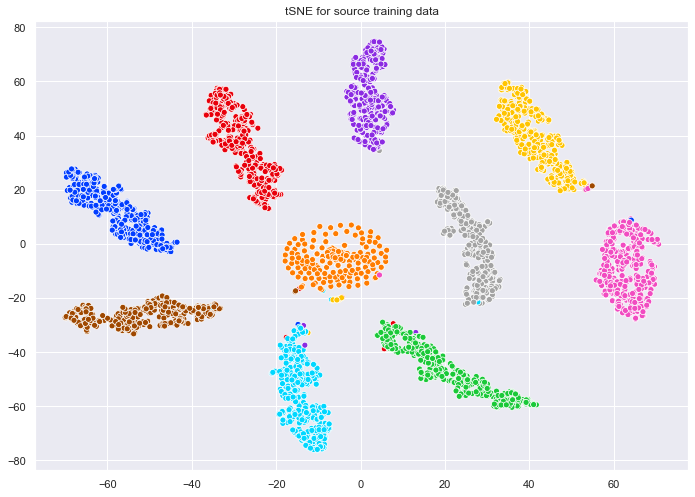

In [49]:
# Evalualtion

from sklearn.manifold import TSNE
import seaborn as sns

source_x_all = torch.empty(0,).to(device)
source_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (source_x, source_y) in tqdm(enumerate(train_mnist_loader), total=len(train_mnist_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    source_x = source_x.to(device).float()
    source_y = source_y.to(device)
    source_x_all = torch.cat([source_x_all, source_x], dim=0)
    source_y_all = torch.cat([source_y_all, source_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
source_x_embedding_all = encoder(source_x_all)
last_layer = CNet(source_x_embedding_all)
source_x_embedding_all.shape


tsne = TSNE()
tsne_res = tsne.fit_transform(source_x_embedding_all.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(tsne_res[:,0], tsne_res[:,1], hue=source_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for source training data')


  5%|▍         | 9/184 [00:00<00:13, 13.39it/s]


Text(0.5, 1.0, 'tSNE for target testing data')

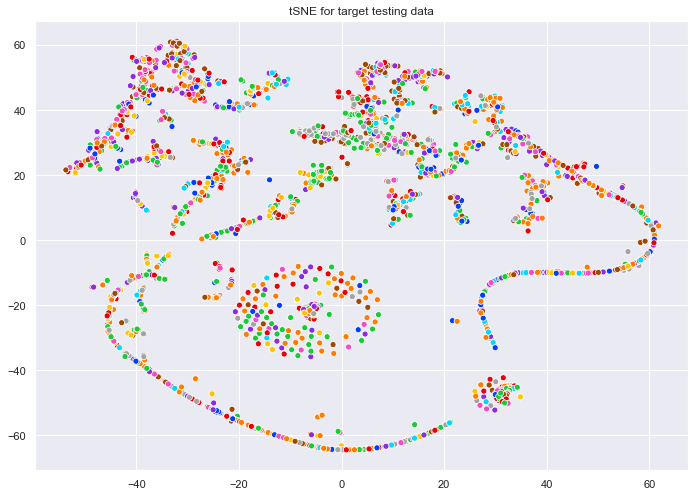

In [51]:

target_x_all = torch.empty(0,).to(device)
target_y_all = torch.empty(0,).to(device).long()
round_ = 0
total_round = 10
for batch_id, (target_x, target_y) in tqdm(enumerate(test_svhn_loader), total=len(test_svhn_loader)):
    optimizerCNet.zero_grad()
    optimizerEncoder.zero_grad()
    target_x = target_x.to(device).float()
    target_y = target_y.to(device)
    target_x_all = torch.cat([target_x_all, target_x], dim=0)
    target_y_all = torch.cat([target_y_all, target_y], dim=0)
    round_ += 1
    if round_ >= total_round:
        break

CNet.eval()
encoder.eval()
CNet.to(device)
encoder.to(device)
target_x_embedding_all = encoder(target_x_all)
last_layer = CNet(target_x_embedding_all)
target_x_embedding_all.shape


target_tsne = TSNE()
target_tsne_res = target_tsne.fit_transform(last_layer.to('cpu').detach())

# plot
# linear unlabeled
sns.set(rc={'figure.figsize':(11.7,8.27)})
palette = sns.color_palette("bright", 10)

g = sns.scatterplot(target_tsne_res[:,0], target_tsne_res[:,1], hue=target_y_all.to('cpu'), legend=False, palette=palette)

plt.title('tSNE for target testing data')